In [104]:
import torch
import matplotlib.pyplot as plt
import random

In [105]:
def generate_data(w, b, num_samples=1000):
    x = torch.normal(0, 1, (num_samples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.1, size=y.shape)  # Adding some noise
    return x, y.reshape((-1,1))
x, y = generate_data(torch.tensor([2.0, -3.0]), torch.tensor([1.0]))
x.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

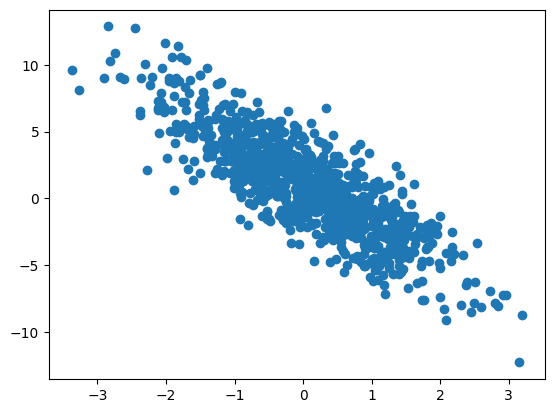

In [106]:
plt.figure()
plt.scatter(x[:, 1].numpy(), y.numpy())
plt.show()

In [107]:

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)

    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i:min(i + batch_size, num_examples)]
        yield features[batch_indices], labels[batch_indices]

# for xi,yi in data_iter(10, x, y):
#     print(xi, yi)
#     break

In [108]:
w, b = torch.normal(0, 0.01, size=(2, 1), requires_grad=True), torch.zeros(1, requires_grad=True)
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [109]:
def squared_loss(y_hat, y):
    return ((y_hat - y) ** 2)/2

In [110]:
def sgd(params, lr):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

In [111]:
lr = 0.003
num_epochs = 3
batch_size = 10
for epoch in range(num_epochs):
    for xi, yi in data_iter(batch_size, x, y):
        y_hat = linreg(xi, w, b)
        loss = squared_loss(y_hat, yi)
        loss.sum().backward()
        sgd([w, b], lr)
    with torch.no_grad():
        train_l = squared_loss(linreg(xi, w, b), yi).mean()
        print(f'epoch {epoch + 1}, loss {train_l:f}')

epoch 1, loss 0.027510
epoch 2, loss 0.003859
epoch 3, loss 0.001028


In [112]:
def create_mask(src, tgt, pad_idx=0):
    """创建掩码"""
    # 源序列掩码
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)
    
    # 目标序列掩码
    tgt_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(3)
    seq_length = tgt.size(1)
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
    tgt_mask = tgt_mask & nopeak_mask
    
    return src_mask, tgt_mask

In [119]:
src_vocab_size = 1000
tgt_vocab_size = 1000
d_model = 512
n_head = 8
num_encoder_layers = 6
num_decoder_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

# 示例输入
batch_size = 2
src_seq_len = 10
tgt_seq_len = 12

src = torch.randint(1, src_vocab_size, (batch_size, src_seq_len))
tgt = torch.randint(1, tgt_vocab_size, (batch_size, tgt_seq_len))


src[0][-1] = 0

# 创建掩码
src_mask, tgt_mask = create_mask(src, tgt)

In [120]:
src_mask

tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True,  True, False]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]]])

In [122]:
def create_mask(src, tgt, pad_idx=0):
    """创建掩码 - 修复版本"""
    # 源序列掩码 [batch_size, 1, 1, src_seq_len]
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)
    
    # 目标序列掩码
    # 填充掩码 [batch_size, 1, tgt_seq_len, 1]
    tgt_pad_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(3)
    
    # 后续位置掩码（防止看到未来信息）
    tgt_seq_len = tgt.size(1)
    subsequent_mask = torch.triu(torch.ones(tgt_seq_len, tgt_seq_len, device=src.device), diagonal=1).bool()
    subsequent_mask = ~subsequent_mask  # 反转，1表示允许，0表示禁止
    subsequent_mask = subsequent_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, tgt_seq_len, tgt_seq_len]
    
    # 组合两种掩码
    tgt_mask = tgt_pad_mask & subsequent_mask
    
    return src_mask, tgt_mask

In [124]:
src = torch.tensor([
        [1, 2, 3, 0, 0],  # 有填充
        [1, 2, 3, 4, 5]   # 无填充
    ])
tgt = torch.tensor([
        [1, 2, 0, 0],     # 有填充
        [1, 2, 3, 4]      # 无填充
    ])
src_mask, tgt_mask = create_mask(src, tgt, 0)

In [133]:
def create_encoder_mask(src, pad_idx=0):
    """
    创建编码器mask
    src: [batch_size, seq_len]
    返回: [batch_size, 1, 1, seq_len] 适合多头注意力的形状
    """
    # 创建padding mask (True表示有效位置，False表示padding位置)
    mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, seq_len]
    return mask

# 在注意力计算中的应用
scores = torch.tensor([[0.2, 0.3, 0.1, 0.2, 0.2],
    [0.1, 0.4, 0.2, 0.2, 0.1],
    [0.3, 0.2, 0.3, 0.1, 0.1],
    [0.2, 0.2, 0.2, 0.2, 0.2],  
    [0.1, 0.1, 0.1, 0.3, 0.4]]  
) 
mask = torch.tensor([True, True, True, False, False])
scores = scores.masked_fill(mask == 0, -1e9)
# if mask is not None:
#     # 将mask为False的位置（padding）的scores设置为极小的负数
#     # 这样在softmax后，这些位置的权重会接近0
#     scores = scores.masked_fill(mask == 0, -1e9)

# attn = F.softmax(scores, dim=-1)
scores

tensor([[ 2.0000e-01,  3.0000e-01,  1.0000e-01, -1.0000e+09, -1.0000e+09],
        [ 1.0000e-01,  4.0000e-01,  2.0000e-01, -1.0000e+09, -1.0000e+09],
        [ 3.0000e-01,  2.0000e-01,  3.0000e-01, -1.0000e+09, -1.0000e+09],
        [ 2.0000e-01,  2.0000e-01,  2.0000e-01, -1.0000e+09, -1.0000e+09],
        [ 1.0000e-01,  1.0000e-01,  1.0000e-01, -1.0000e+09, -1.0000e+09]])

In [135]:
import torch.nn.functional as F
attn = F.softmax(scores, dim=-1)
attn

tensor([[0.3322, 0.3672, 0.3006, 0.0000, 0.0000],
        [0.2894, 0.3907, 0.3199, 0.0000, 0.0000],
        [0.3443, 0.3115, 0.3443, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000]])

In [139]:
def get_attn_pad_mask(seq_q, seq_k):                       # seq_q: [batch_size, seq_len] ,seq_k: [batch_size, seq_len]
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)          # 判断 输入那些含有P(=0),用1标记 ,[batch_size, 1, len_k]
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # 扩展成多维度

print(src)
get_attn_pad_mask(src, src)

tensor([[1, 2, 3, 0, 0],
        [1, 2, 3, 4, 5]])


tensor([[[False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True]],

        [[False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]]])